### Stock Market Analysis with Machine Learning


# New Section

In [ ]:
!pip install -q pandas-ta

     |████████████████████████████████| 115 kB 4.9 MB/s 


In [ ]:
# Import packages
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight') # Because of the nice style.

# Constants 
CWD = Path().cwd()
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# Helper methods
def load_data(filename:str = "", index_col = None):
    return pd.DataFrame(pd.read_csv(filename, index_col=index_col, parse_dates=True))

def signal(v, minimum=30, maximum=70):
    """
    Sets a value for indicating Buy, Sell, or Hold.
    """
    if abs(v) >= maximum:
        return -1
    elif abs(v) <= minimum:
        return 1
    else:
        return 0

def preprocess(raw_data=None, drop_columns=[]):
    """
    Preprocess stock history for machine learning.
    
    :param raw_data: Pandas dataframe of unprocessed stock history data.
    :param drop_columns: [] Array of columns to drop.
    :returns: a processed Pandas DataFrame.
    """

    # Make a local copy
    pp_data = raw_data.copy() 
    # Lower case column names
    pp_data.columns = pp_data.columns.str.lower() 

    # Setting up new attributes, which we'll use as features later
    pp_data['sma20'] = pp_data.close.rolling(window=20).mean()
    pp_data['sma50'] = pp_data.close.rolling(window=50).mean()
    pp_data['ema12'] = pp_data.close.ewm(span=12, adjust=False).mean()
    pp_data['ema26'] = pp_data.close.ewm(span=26, adjust=False).mean()
    pp_data['macd'] = pp_data['ema12'] - pp_data['ema26']
    pp_data['rsi'] = ta.rsi(pp_data.close)
    pp_data['signal'] = pp_data.rsi.shift(-1).apply(lambda r: signal(r))


    # Drop all NaN 
    pp_data.dropna(inplace = True)
    if len(drop_columns) > 0:
        pp_data.drop(columns=drop_columns, inplace=True)

    # Sort ascending order, meaning from smallest to largest, we are focused on timeline
    pp_data = pp_data.sort_index(ascending=True, axis=0)
    
    return pp_data

In [ ]:
data = load_data(CWD.parent / "stock_data.csv", 'Date')
data = preprocess(data, drop_columns=['ticker'])
data.head()

,high,low,open,close,volume,adj close,sma20,sma50,ema12,ema26,macd,rsi,signal
Date,,,,,,,,,,,,,
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,40.926430,57.414500,57.221400,57.072127,57.307740,-0.235613,18.981307,1
2015-01-02,29.174999,28.420000,29.000000,28.674999,21170000.0,24.490051,29.343750,29.420900,29.665783,29.481929,0.183854,42.851629,0
2015-01-02,50.331429,48.731430,49.151428,49.848572,13475000.0,49.848572,60.612428,60.218771,59.491800,60.103749,-0.611949,14.612886,1
2015-01-02,37.160000,36.110001,36.669998,36.360001,23605600.0,29.320631,21.211500,19.875200,22.913323,21.392870,1.520452,95.651100,-1
2015-01-02,18.383287,17.974569,18.192553,18.274296,21604483.0,14.435908,64.846264,64.711356,59.708570,63.127004,-3.418434,4.728080,1


In [ ]:
# Testing for any correlation between attributes, 
# the 'signal' attribute is more correlated with the 'close', 'open'.
corr_matrix = data.corr()
corr_matrix['open'].sort_values(ascending=True)

volume      -0.225865
signal      -0.049505
rsi          0.094666
macd         0.152610
sma50        0.981277
sma20        0.992555
ema26        0.992929
ema12        0.996968
adj close    0.998507
close        0.999676
low          0.999816
high         0.999859
open         1.000000
Name: open, dtype: float64

##### Initializing the machine learning and training/test 

In [ ]:
# Setup a pipeline
pipe = Pipeline([
    ('Scaler', MinMaxScaler()),
    ('Classifier', KNeighborsClassifier(n_neighbors=15))
])

X = data.drop(columns=['signal', 'rsi'], axis=1)
y = data['signal']

# Creating the training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200, stratify=y)

# Train
pipe.fit(X_train, y_train)

# Predict
pred = pipe.predict(X_test)

scores = cross_val_score(pipe, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_score = np.sqrt(-scores)

##### Performance and assessment of the learning model

In [ ]:
print(f"Training set score: {pipe.score(X_train,y_train)}")
print(f"Test set score: {pipe.score(X_test,y_test)}")
print(f"\nCorss-validation:\n\nScores: {scores}")
print(f"Mean: {scores.mean()}")
print(f"Standard deviation: {scores.std()}\n")
print(f"Neg Mean Sqred error: {rmse_score}")
print("\nClassification Report:")
print(classification_report(y_test, pred, target_names=['Buy', 'Hold', 'Sell']))

Training set score: 0.8947368421052632
Test set score: 0.8853380677615031

Corss-validation:

Scores: [-0.11895251 -0.12516644 -0.126498   -0.15446072 -0.15446072 -0.18109188
 -0.13981358 -0.14602752 -0.15712383 -0.14831261]
Mean: -0.14519078174039113
Standard deviation: 0.017553777990123025

Neg Mean Sqred error: [0.34489492 0.3537887  0.35566558 0.39301491 0.39301491 0.42554891
 0.37391654 0.38213547 0.39638849 0.38511376]

Classification Report:
              precision    recall  f1-score   support

         Buy       0.70      0.20      0.31       644
        Hold       0.89      0.99      0.94      5788
        Sell       0.96      0.40      0.56       327

    accuracy                           0.89      6759
   macro avg       0.85      0.53      0.60      6759
weighted avg       0.87      0.89      0.86      6759



##### Results after first iteration

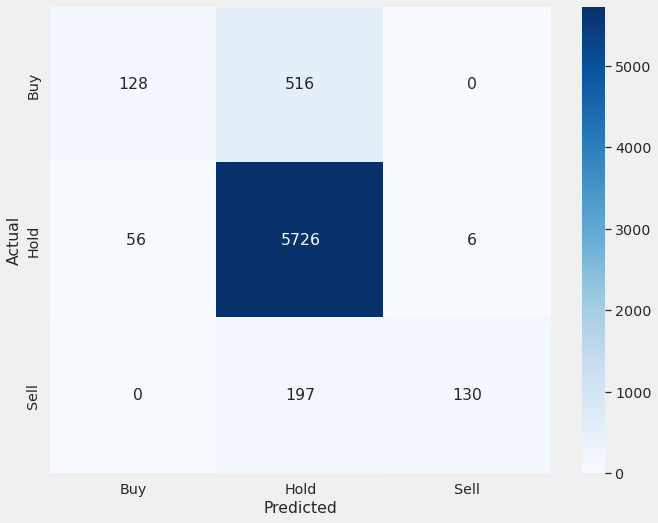

In [ ]:
plt.figure(figsize = (10,8))
positions = ['Buy', 'Hold', 'Sell']
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, positions, positions)
sns.set(font_scale = 1.3)
sns.heatmap(df_cm, annot=True, fmt='3.0f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

DecisionTreeClassifier

In [ ]:
pipe_tree = Pipeline([
    ('Scaler', MinMaxScaler()),
    ('Classifier', DecisionTreeClassifier(max_depth=8))
])

In [ ]:
# Train
pipe_tree.fit(X_train, y_train)


Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Classifier', DecisionTreeClassifier())])

In [ ]:
# Predict
pred_tree = pipe_tree.predict(X_test)

In [ ]:
scores_tree = cross_val_score(pipe_tree, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_score_tree = np.sqrt(-scores_tree)

In [ ]:
print(f"Training set score: {pipe_tree.score(X_train,y_train)}")
print(f"Test set score: {pipe_tree.score(X_test,y_test)}")
print(f"\nCorss-validation:\n\nScores: {scores}")
print(f"Mean: {scores_tree.mean()}")
print(f"Standard deviation: {scores_tree.std()}\n")
print(f"Neg Mean Sqred error: {rmse_score_tree}")
print("\nClassification Report:")
print(classification_report(y_test, pred_tree, target_names=['Buy', 'Hold', 'Sell']))

Training set score: 1.0
Test set score: 0.869655274448883

Corss-validation:

Scores: [-0.26009765 -0.23391034 -0.21571238 -0.21171771 -0.24012428 -0.25699068
 -0.25920994 -0.22947182 -0.20772304 -0.17717584]
Mean: -0.2268608896446735
Standard deviation: 0.025222567725429672

Neg Mean Sqred error: [0.49721818 0.48501742 0.46967517 0.45332524 0.48866422 0.51905544
 0.49811005 0.46730664 0.45771    0.41933721]

Classification Report:
              precision    recall  f1-score   support

         Buy       0.52      0.51      0.52       644
        Hold       0.93      0.92      0.92      5788
        Sell       0.58      0.63      0.60       327

    accuracy                           0.87      6759
   macro avg       0.68      0.69      0.68      6759
weighted avg       0.87      0.87      0.87      6759



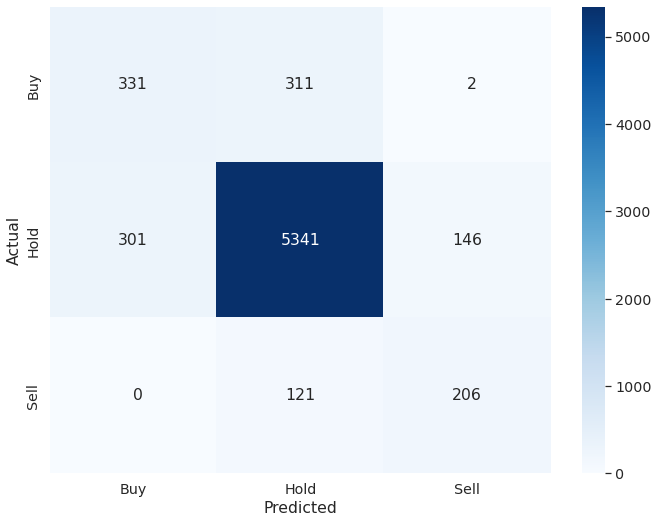

In [ ]:
plt.figure(figsize = (10,8))
positions = ['Buy', 'Hold', 'Sell']
cm = confusion_matrix(y_test, pred_tree)
df_cm = pd.DataFrame(cm, positions, positions)
sns.set(font_scale = 1.3)
sns.heatmap(df_cm, annot=True, fmt='3.0f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()